In [1]:
import pandas as pd
from api import JolpicaF1API
from quali_plot_utils import plot_quali_drivers, plot_quali_constructors
from race_plot_utils import plot_lap_times_boxplot, plot_mean_lap_times, plot_std_dev_lap_times
from utils import get_constructor_colours, convert_lap_time_to_ms, convert_to_time_format

In [2]:
api = JolpicaF1API()

In [3]:
constructorColors = get_constructor_colours()

# Qualifying Analysis

In [4]:
qualiResults = api.get_qualifying_results('2025', 1)
qualiResults = qualiResults['MRData']['RaceTable']['Races']
qualiResults = qualiResults[0]['QualifyingResults']

qualiDf = pd.json_normalize(qualiResults, sep='_')

sessionList = ["Q1", "Q2", "Q3"]

for session in sessionList:
    qualiDf[f'{session}Ms'] = qualiDf[session].apply(convert_lap_time_to_ms)

sessionMsColumns = [f'{s}Ms' for s in sessionList]

if sessionMsColumns:
    qualiDf['fastestLapMs'] = qualiDf[sessionMsColumns].min(axis=1, skipna=True)
    qualiDf['fastestLap'] = qualiDf['fastestLapMs']

qualiDf['timeDiff'] = (qualiDf['fastestLapMs'] - qualiDf['fastestLapMs'].min()) / 6000
qualiDf = qualiDf.sort_values(by='timeDiff')
qualiDf['color'] = qualiDf['Constructor_name'].map(constructorColors)

f:\Coding\Portfolio\F1DataAnalysis\quali_plot_utils.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  quali_data['color'].fillna('gray', inplace=True)


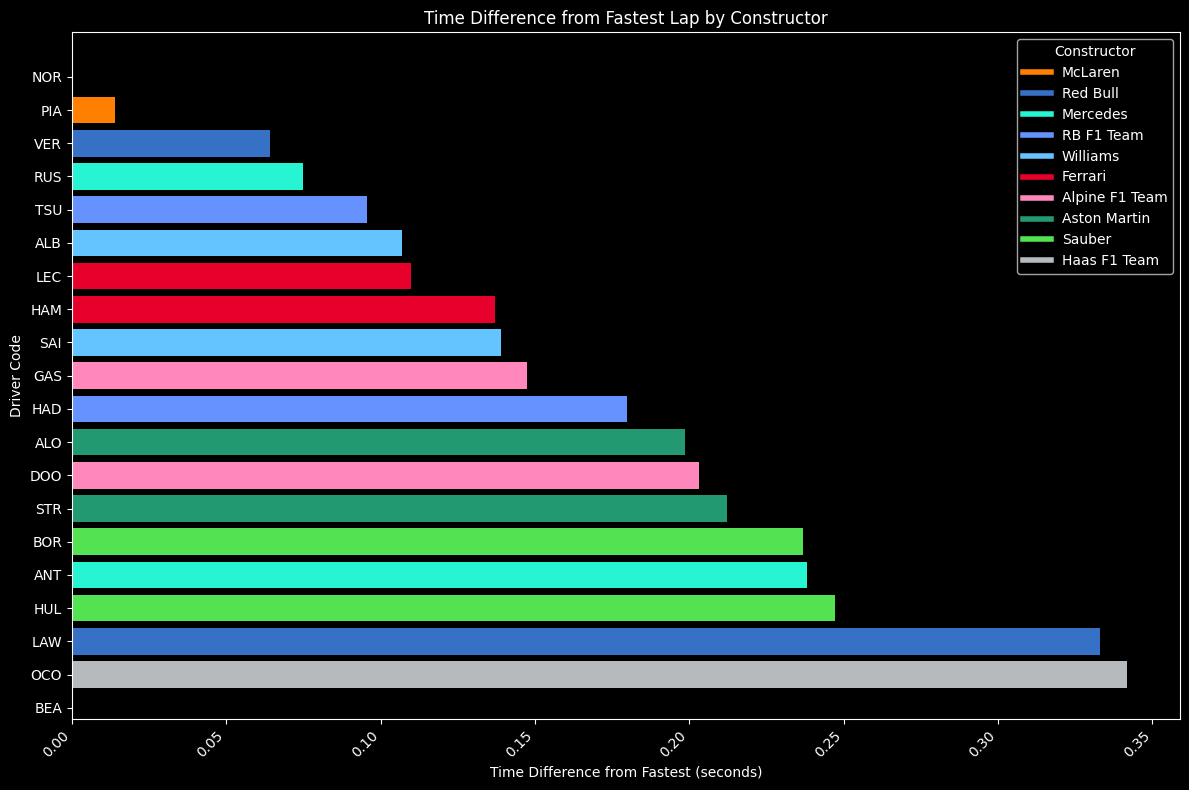

In [5]:
plot_quali_drivers(qualiDf)

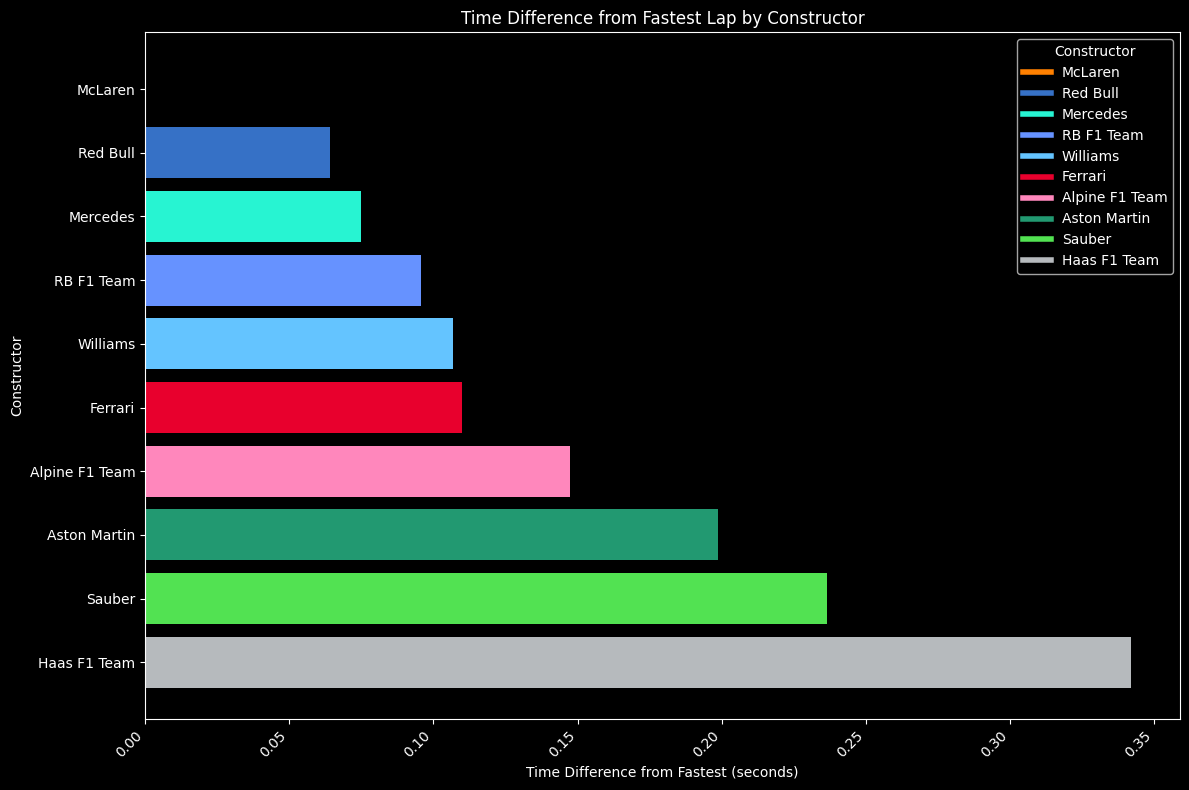

In [6]:
plot_quali_constructors(qualiDf)

# Race Analysis

In [7]:
raceResults = api.get_laps('2025', 1)
raceLaps = raceResults['MRData']['RaceTable']['Races'][0]['Laps']

Fetching 921 race laps over 10 pages
Successfully fetched 66 race laps


In [8]:
lapTimingsDf = pd.json_normalize(raceLaps, record_path='Timings', meta=['number'])
lapTimingsDf['timeMs'] = lapTimingsDf['time'].apply(convert_lap_time_to_ms)
lapTimingsDf['timeMinutes'] = lapTimingsDf['timeMs'] / 60000

In [9]:
driverStandings = api.get_drivers('2025', 1)
driverData = driverStandings['MRData']['StandingsTable']['StandingsLists'][0]
driverDf = pd.json_normalize(driverData, record_path='DriverStandings')

In [10]:
driverInfoDf = driverDf[['Driver.driverId', 'Driver.permanentNumber', 'Driver.code', 
                        'Driver.givenName', 'Driver.familyName', 'Constructors']]
driverInfoDf.columns = ['driverId', 'number', 'code', 'firstName', 'lastName', 'constructors']
driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(
    lambda x: x[0]['name'] if x else None
)
driverInfoDf = driverInfoDf[['driverId', 'number', 'code', 'firstName', 'lastName', 'constructor']]

C:\Users\Administrator\AppData\Local\Temp\ipykernel_22248\3943629290.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  driverInfoDf['constructor'] = driverInfoDf['constructors'].apply(


In [ ]:
mergedRaceDf = pd.merge(lapTimingsDf, driverInfoDf, on='driverId', how='right', validate="1:1")
mergedRaceDf = mergedRaceDf.rename(columns={'number_x': 'lap', 'number_y': 'driverNumber'})

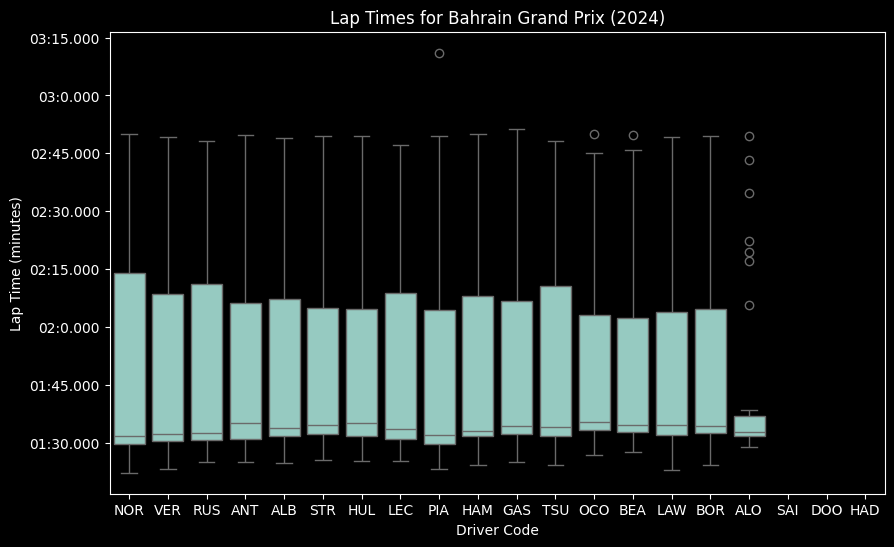

In [12]:
plot_lap_times_boxplot(mergedRaceDf)

In [13]:
pitStopData = api.get_pitstops('2025', 1)
pitStops = pitStopData['MRData']['RaceTable']['Races'][0]['PitStops']
pitStopDf = pd.json_normalize(pitStops, sep=',')

In [14]:
mergedRaceDf['lap'] = mergedRaceDf['lap'].dropna().astype(int)
pitStopDf['lap'] = pitStopDf['lap'].dropna().astype(int)

In [ ]:
mergedWithPitstops = pd.merge(mergedRaceDf, pitStopDf, on=['driverId', 'lap'], how='left', validate="1:1", indicator=True)
mergedWithPitstops = mergedWithPitstops.rename(columns={'time_x': 'lapTime', 'time_y': 'pitStopTime'})

In [16]:
mergedWithPitstops['timeMs'] = pd.to_numeric(mergedWithPitstops['timeMs'], errors='coerce')
mergedWithPitstops['duration'] = pd.to_numeric(mergedWithPitstops['duration'], errors='coerce')
pitstop_adjustments = mergedWithPitstops[mergedWithPitstops['_merge'] == 'both'].copy()

In [17]:
pitstop_adjustments['lap'] = pitstop_adjustments['lap'] + 1
pitstop_adjustments['pitStopMs'] = pitstop_adjustments['duration'] * 1000

In [ ]:
adjustedLapTimes = pd.merge(
    mergedRaceDf,
    pitstop_adjustments[['driverId', 'lap', 'pitStopMs']],
    on=['driverId', 'lap'],
    how='left',
    validate="1:1",
    suffixes=('', '_adjustment')
)

In [19]:
adjustedLapTimes['adjustedTimeMs'] = adjustedLapTimes['timeMs'] - adjustedLapTimes['pitStopMs'].fillna(0)
adjustedLapTimes['adjustedTimeMinutes'] = adjustedLapTimes['adjustedTimeMs'] / 60000

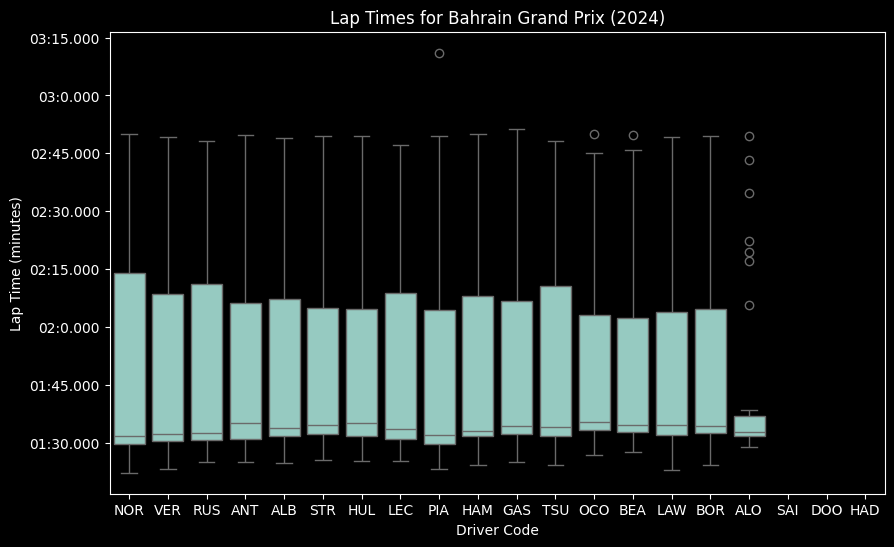

In [20]:
plot_lap_times_boxplot(adjustedLapTimes)

In [21]:
meanLapTimeMs = mergedRaceDf['timeMs'].mean()
stdLapTimeMs = mergedRaceDf['timeMs'].std()
meanLapTime = convert_to_time_format(meanLapTimeMs)
stdLapTime = convert_to_time_format(stdLapTimeMs)

In [22]:
meanLapTimeMsNoPitstops = adjustedLapTimes['adjustedTimeMs'].mean()
stdLapTimeMsNoPitstops = adjustedLapTimes['adjustedTimeMs'].std()
meanLapTimeNoPitstops = convert_to_time_format(meanLapTimeMsNoPitstops)
stdLapTimeNoPitstops = convert_to_time_format(stdLapTimeMsNoPitstops)

In [23]:
stats = mergedRaceDf.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('timeMs', 'mean'),
    stdTimeMs=('timeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convert_to_time_format)
stats['stdTime'] = stats['stdTimeMs'].apply(convert_to_time_format)

In [24]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
9,Nico,Hülkenberg,1:47.802,0:22.197
18,Lance,Stroll,1:47.784,0:22.328
14,Esteban,Ocon,1:48.060,0:22.551
6,Pierre,Gasly,1:47.943,0:22.738
0,Alexander,Albon,1:47.703,0:22.885
2,Andrea Kimi,Antonelli,1:47.656,0:22.979
3,Oliver,Bearman,1:48.186,0:22.982
19,Yuki,Tsunoda,1:48.003,0:23.345
8,Lewis,Hamilton,1:47.873,0:23.397
16,George,Russell,1:47.627,0:23.764


In [25]:
stats = adjustedLapTimes.groupby(['driverId', 'firstName', 'lastName']).agg(
    meanTimeMs=('adjustedTimeMs', 'mean'),
    stdTimeMs=('adjustedTimeMs', 'std')
).reset_index()
stats['meanTime'] = stats['meanTimeMs'].apply(convert_to_time_format)
stats['stdTime'] = stats['stdTimeMs'].apply(convert_to_time_format)

In [26]:
stats_subset = stats[['firstName', 'lastName', 'meanTime', 'stdTime']]
stats_subset.sort_values("stdTime")

,firstName,lastName,meanTime,stdTime
6,Pierre,Gasly,1:46.459,0:20.695
9,Nico,Hülkenberg,1:46.282,0:20.966
18,Lance,Stroll,1:46.316,0:21.031
14,Esteban,Ocon,1:46.496,0:21.174
0,Alexander,Albon,1:46.232,0:21.267
1,Fernando,Alonso,1:43.051,0:21.362
8,Lewis,Hamilton,1:46.376,0:21.512
19,Yuki,Tsunoda,1:46.563,0:21.544
2,Andrea Kimi,Antonelli,1:46.150,0:21.578
3,Oliver,Bearman,1:46.515,0:21.938


In [27]:
print("\nComparison of Mean Lap Times and Standard Deviations:")
print(f"1. Unfiltered Data      - Mean Lap Time: {meanLapTime}, Standard Deviation: {stdLapTime}")
print(f"2. Pitstops Removed     - Mean Lap Time: {meanLapTimeNoPitstops}, Standard Deviation: {stdLapTimeNoPitstops}")


Comparison of Mean Lap Times and Standard Deviations:
1. Unfiltered Data      - Mean Lap Time: 1:47.665, Standard Deviation: 0:23.397
2. Pitstops Removed     - Mean Lap Time: 1:46.159, Standard Deviation: 0:21.956


In [28]:
baseStats = mergedRaceDf.groupby(['driverId', 'firstName', 'lastName', 'constructor'])['timeMs'].agg(['mean', 'std']).reset_index()
baseStats.columns = ['driverId', 'firstName', 'lastName', 'constructor', 'baseMean', 'baseStd']

adjustedStats = adjustedLapTimes.groupby(['driverId', 'firstName', 'lastName', 'constructor'])['adjustedTimeMs'].agg(['mean', 'std']).reset_index()
adjustedStats.columns = ['driverId', 'firstName', 'lastName', 'constructor', 'adjustedMean', 'adjustedStd']

In [ ]:
combinedStats = pd.merge(baseStats, adjustedStats, on=['driverId', 'firstName', 'lastName', 'constructor'], how="inner", validate="1:1")
finalStats = combinedStats[['firstName', 'lastName', 'constructor', 'baseMean', 'baseStd', 'adjustedMean', 'adjustedStd']]

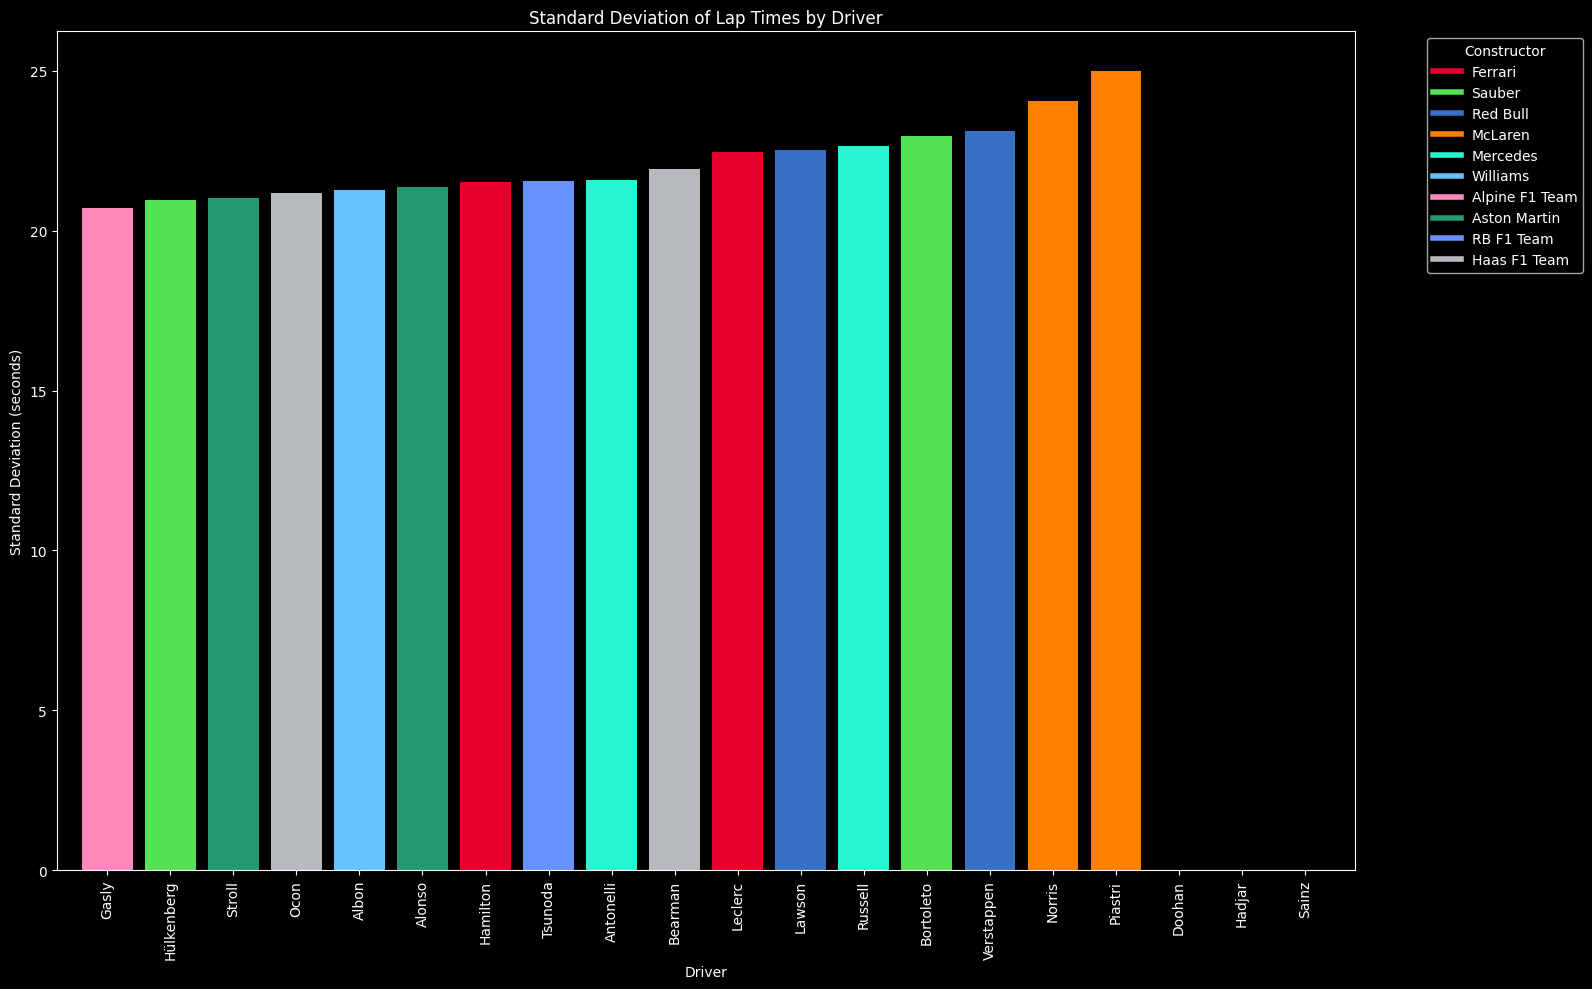

In [30]:
plot_std_dev_lap_times(finalStats, constructorColors)

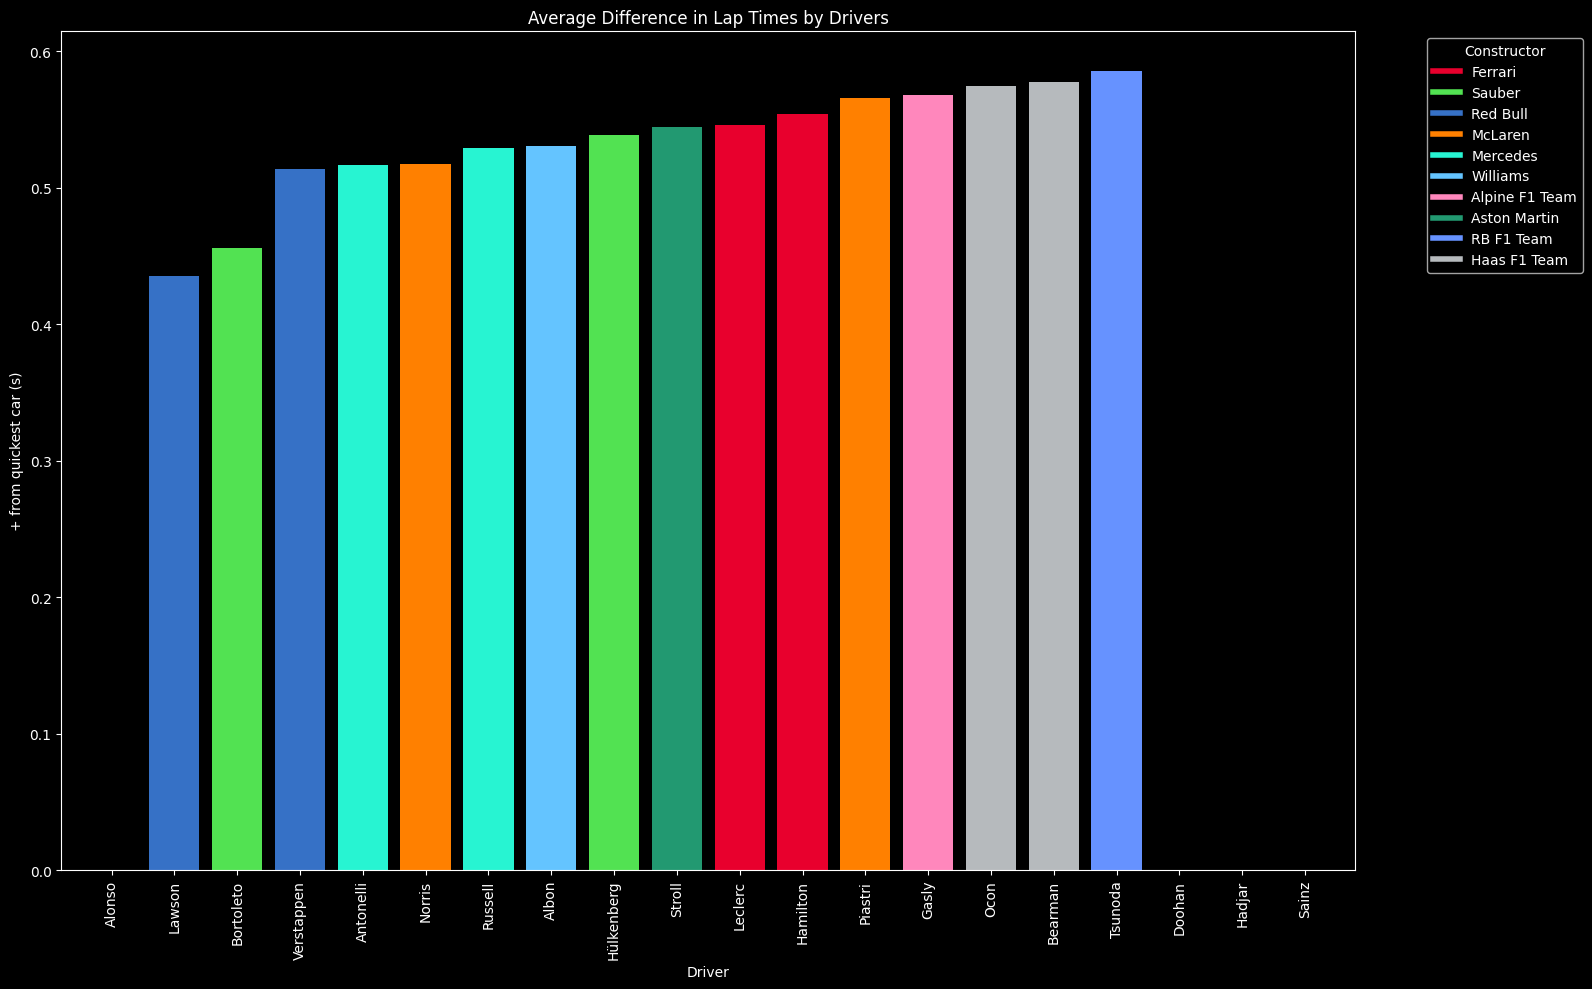

In [31]:
plot_mean_lap_times(finalStats, constructorColors)